In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Set device variable

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

# Prepare Dataset objects

In [3]:
data_path = './'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

n_out = 10

# Prepare Dataloader objects

In [4]:
#kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available()else {}

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True)#,  **kwargs)

val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,shuffle=False)#, **kwargs)

# Build a Deep Neural Network with Skip Connections

**With depth, the complexity of the function the network is able to approximate generally increases.**

For example, in regard to computer vision, a shallower network could identify a person’s shape in a photo, whereas a deeper network could identify the person, the face on their top half, and the mouth within the face. Depth allows a model to deal with hierarchical information when we need to understand the context in order to say something about some input.

**However, depth comes with some additional challenges, which prevented deep learning models from reaching 20 or more layers until late 2015.** Adding depth to a model generally makes training harder to converge.

In December 2015, Kaiming He and coauthors presented residual networks (ResNets), an architecture that uses a simple trick to allow very deep networks to be successfully trained. **Thinking about backpropagation, we can appreciate that a skip connection, or a sequence of skip connections in a deep network, creates a direct path from the deeper parameters to the loss.**

The following shows a model with skip connection

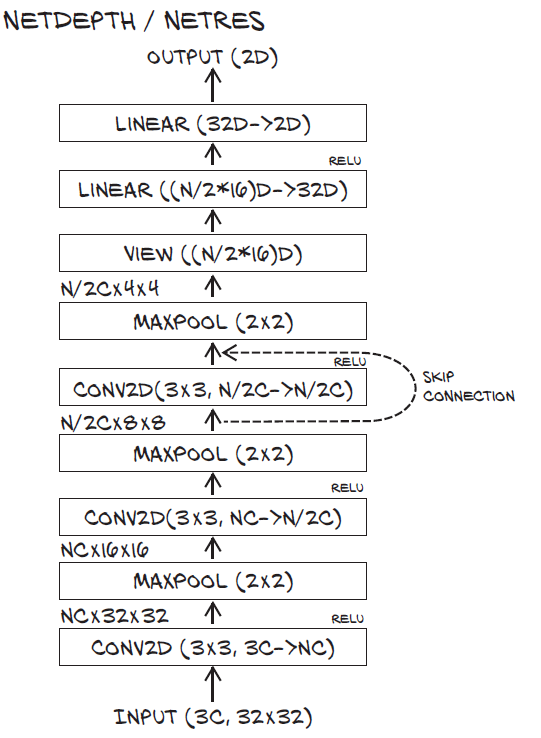

In [5]:
import torch.nn.functional as F

class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, n_out)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetRes(n_chans1=16)

# model.to(device)

# Start Training

In [6]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    model.train(True)
    for imgs, labels in train_loader:
        #imgs, labels = imgs.to(device), labels.to(device)
        
        outputs = model(imgs)   # important:  nn.Conv2d expects a B × C × H × W shaped tensor as input
        train_loss = loss_fn(outputs, labels)
  
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            #imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            val_loss = loss_fn(outputs, labels)
            
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print("Epoch: %d, train_loss: %f, val_loss: %f, val_accuracy: %f" % (epoch, float(train_loss), float(val_loss), (correct / total)))

Epoch: 0, train_loss: 2.029492, val_loss: 1.973268, val_accuracy: 0.263000
Epoch: 1, train_loss: 1.779353, val_loss: 1.733700, val_accuracy: 0.328200


KeyboardInterrupt: 